In [1]:
import pandas as pd
from core.repository import load_financial
from base.timeutil import YearMonth
import sqlite3
from core.repository.maria.conn import maria_home

db_file = "analysis.db"

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(db_file))
except:
    print("Fetching month chart...")
    month_chart = pd.read_sql("""
        select month_chart.*, stock.name, stock.exchange from month_chart
        join stock on month_chart.code = stock.code;
    """, maria_home())
    print("Building layer1...")

    begin = YearMonth(2002, 6)
    end = YearMonth(2023, 1)

    month_chart["년월"] = [YearMonth.from_date(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.to(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        df1 = df1[df1["val_last"] >= 1000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")
        df2.loc[df2["val_last"] == 0, "close"] = 0

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = str(layer1["확정실적"])
    layer1.to_sql("layer1", sqlite3.connect(db_file), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,매도가,...,매출총이익,영업이익,당기순이익,GP_YoY,O_YoY,E_YoY,GP_QoQ,O_QoQ,E_QoQ,확정실적
0,060310,3S,코스닥,2002-06,2002-07,6960000000,2002-06-28,1265,2752200,1444.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.162907,-0.071261,-0.048631,0 2002-1Q\n1 2002-1Q\n2 ...
1,006840,AK홀딩스,유가증권,2002-06,2002-07,109500000000,2002-06-28,11427,117982,10394.0,...,4.355962e+10,1.725886e+10,1.160399e+10,0.475058,2.260823,54.762239,0.587139,2.184726,3.645441,0 2002-1Q\n1 2002-1Q\n2 ...
2,054620,APS홀딩스,코스닥,2002-06,2002-07,24255600000,2002-06-28,7140,2040599,5351.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.575499,-0.640319,-0.579271,0 2002-1Q\n1 2002-1Q\n2 ...
3,001460,BYC,유가증권,2002-06,2002-07,32667364500,2002-06-28,52300,13860,60700.0,...,5.854057e+10,1.672713e+10,1.683980e+10,0.107540,0.695770,0.044526,0.391213,1.743625,0.721907,0 2002-1Q\n1 2002-1Q\n2 ...
4,013720,CBI,코스닥,2002-06,2002-07,6948334500,2002-06-28,58,463476,57.0,...,2.703707e+09,1.114430e+09,1.039940e+09,0.089404,0.903209,0.693611,0.661352,7.388766,2.376448,0 2002-1Q\n1 2002-1Q\n2 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380953,189980,흥국에프엔비,코스닥,2022-12,2023-01,107167998090,2022-12-29,2670,4729047,2865.0,...,3.220682e+10,1.060806e+10,1.036907e+10,0.473492,0.688273,0.432820,0.225383,0.307582,0.349857,0 2002-1Q\n1 2002-1Q\n2 ...
380954,000540,흥국화재,유가증권,2022-12,2023-01,216497713650,2022-12-29,3370,15972406,3550.0,...,NaN,1.508610e+11,NaN,NaN,0.843703,NaN,NaN,0.401228,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
380955,003280,흥아해운,유가증권,2022-12,2023-01,325775738145,2022-12-29,1355,4552374,1516.0,...,3.308796e+10,2.261262e+10,-1.589100e+10,7.557215,4.676515,-3.880978,40.456585,4.941482,8.103269,0 2002-1Q\n1 2002-1Q\n2 ...
380956,037440,희림,코스닥,2022-12,2023-01,114164295000,2022-12-29,8200,14299451,10670.0,...,2.774961e+10,1.050311e+10,9.644705e+09,0.114353,0.165029,0.670366,0.612092,1.116619,2.517199,0 2002-1Q\n1 2002-1Q\n2 ...


In [2]:

import numpy as np

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("P")

result = pd.DataFrame()
yms = layer2["매수년월"].unique()

earning_factor_weights = {
    "GP_QoQ": 2,
    "O_QoQ": 2,
    "GP_YoY": 1,
    "O_YoY": 1
}

recipes = []
for gppw in [4, 5, 6, 8]:
    for pw in [-6, -8, -10, -12]:
        recipes.append({"GP/P": gppw, "P": pw, **earning_factor_weights})

# 위 코드는 향후 recipe 생성 과정에서 사용할 것

from core.strategy import recipe

recipes = [recipe, recipe]

print(pd.DataFrame(recipes))

for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_pct = f"{factor}_pct"
        df[colname_pct] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    for i in range(len(recipes)):
        factor = f"super{i}"
        # 1. 레시피를 구성하는 개별 팩터 분위(percentile) * 가중치의 총합을 구함
        sv = sum([df[f"{k}_pct"] * w if w > 0 else (1 - df[f"{k}_pct"]) * abs(w) for k, w in recipe.items()])
        # 2. 위의 시리즈에 가중치의 총합을 나눈다 => 0~1 사이 값으로 일반화됨
        df[factor] = sv / sum([abs(w) for w in recipe.values()])
        df[f"{factor}_pct"] = np.ceil(df[factor].rank(method="min", pct=True) * 100)

    result = pd.concat([result, df])

factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2
2022-12

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,매도가,...,O/A_pct,E/A_pct,GP/EQ_pct,O/EQ_pct,E/EQ_pct,P_pct,super0,super0_pct,super1,super1_pct
0,060310,3S,코스닥,2002-06,2002-07,6960000000,2002-06-28,1265,2752200,1444.0,...,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
1,006840,AK홀딩스,유가증권,2002-06,2002-07,109500000000,2002-06-28,11427,117982,10394.0,...,52.0,53.0,37.0,48.0,50.0,83.0,11.318182,40.0,11.318182,40.0
2,054620,APS홀딩스,코스닥,2002-06,2002-07,24255600000,2002-06-28,7140,2040599,5351.0,...,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN
3,001460,BYC,유가증권,2002-06,2002-07,32667364500,2002-06-28,52300,13860,60700.0,...,60.0,72.0,48.0,45.0,61.0,53.0,36.363636,89.0,36.363636,89.0
4,013720,CBI,코스닥,2002-06,2002-07,6948334500,2002-06-28,58,463476,57.0,...,74.0,80.0,52.0,60.0,73.0,6.0,37.772727,92.0,37.772727,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380953,189980,흥국에프엔비,코스닥,2022-12,2023-01,107167998090,2022-12-29,2670,4729047,2865.0,...,65.0,65.0,68.0,72.0,76.0,45.0,22.136364,69.0,22.136364,69.0
380954,000540,흥국화재,유가증권,2022-12,2023-01,216497713650,2022-12-29,3370,15972406,3550.0,...,35.0,NaN,NaN,93.0,NaN,68.0,NaN,NaN,NaN,NaN
380955,003280,흥아해운,유가증권,2022-12,2023-01,325775738145,2022-12-29,1355,4552374,1516.0,...,73.0,18.0,46.0,83.0,16.0,79.0,6.590909,32.0,6.590909,32.0
380956,037440,희림,코스닥,2022-12,2023-01,114164295000,2022-12-29,8200,14299451,10670.0,...,68.0,66.0,75.0,81.0,84.0,48.0,19.272727,63.0,19.272727,63.0


18/18

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil


2002-06 2023-01
   GP/P  P  GP_YoY  GP_QoQ  O_YoY  O_QoQ
0     8 -8       1       2      1      2
1     8 -8       1       2      1      2


,spearman,top,h3,h5,h10,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,,,
super0,0.948923,0.435549,0.416581,0.414964,0.370918,-0.123616,0.538580,-0.010881,0.100318,0.091060,-0.549461
super1,0.948923,0.435549,0.416581,0.414964,0.370918,-0.123616,0.538580,-0.010881,0.100318,0.091060,-0.549461
GP/P,0.901830,0.208073,0.210046,0.210394,0.208347,-0.125247,0.335641,-0.254880,0.095770,0.120266,-0.590521
EQ/P,0.910207,0.194268,0.201242,0.204720,0.204705,-0.125715,0.330434,-0.222030,0.090928,0.096161,-0.552464
O_QoQ,0.828863,0.141048,0.149771,0.196762,0.188333,0.006506,0.190256,-0.436183,0.090151,0.093919,-0.626440
O/P,0.784506,0.170527,0.204143,0.192551,0.186391,-0.012095,0.204646,-0.356822,0.092131,0.103004,-0.561469
O_YoY,0.541806,0.254777,0.190072,0.171374,0.146283,0.026973,0.144401,-0.418540,0.093776,0.095638,-0.562941
E/P,0.726205,0.131790,0.116856,0.145992,0.169134,-0.051281,0.197273,-0.374203,0.091449,0.094673,-0.571476
GP/A,0.512439,0.119430,0.107831,0.120088,0.119976,-0.111595,0.231684,-0.364579,0.093376,0.103563,-0.596263


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

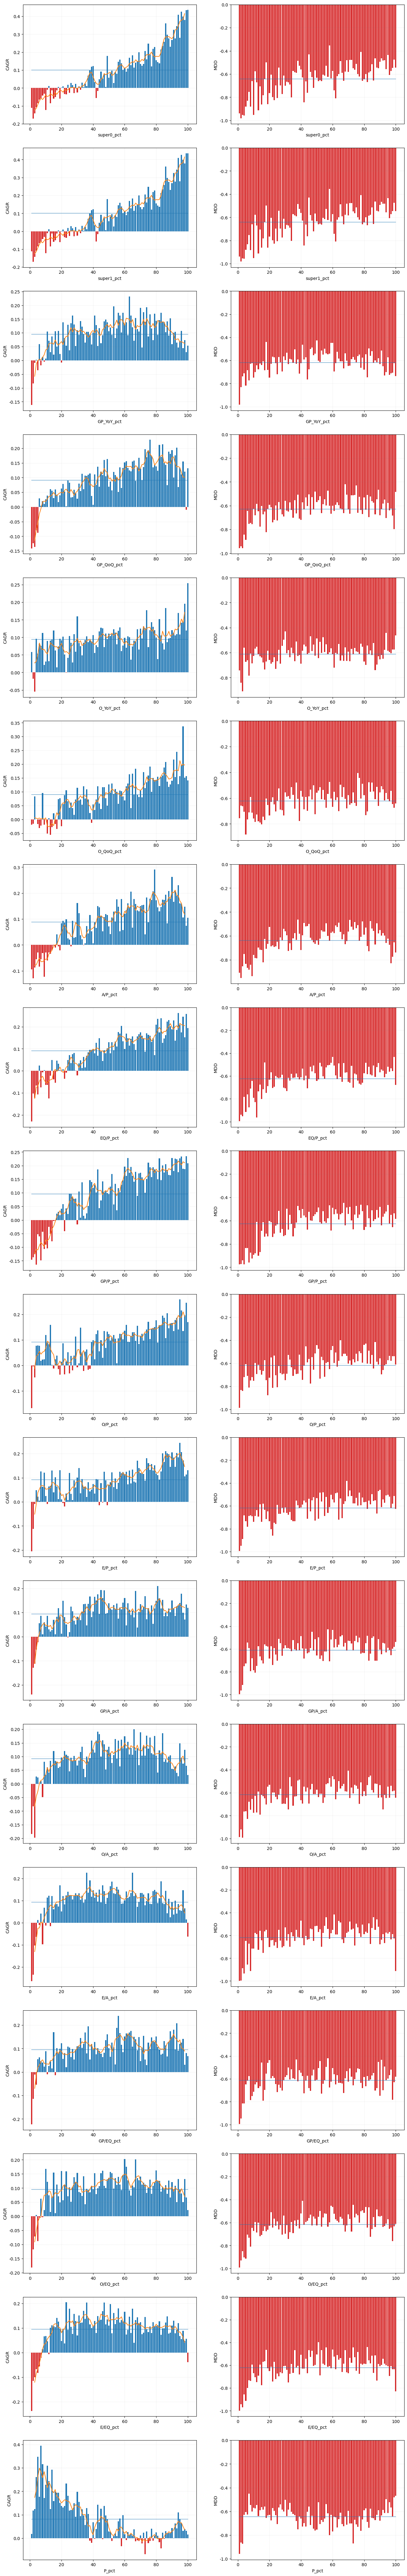

In [11]:
import matplotlib.pyplot as plt
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth
from datetime import date

# plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

target_factors = factors
# target_factors = [f for f in factors if f.startswith("super")]
fig, subplots = plt.subplots(len(target_factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(target_factors))

summary = pd.DataFrame()
for i in range(len(target_factors)):
    print(f"\r{i + 1}/{len(target_factors)}", end="")
    factor = factors[i]
    colname_pct = f"{factor}_pct"
    percentiles = sorted(set(result[colname_pct].dropna()))
    mean_by_pct = []
    cagr_by_pct = []
    mdd_by_pct = []
    for pct in percentiles:
        by_pct = result[result[colname_pct] == pct]
        return_by_ym = by_pct.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(by_pct["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_pct.append(return_by_ym.mean())
        cagr_by_pct.append(cagr(1, last, by_pct["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_pct.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_pct_series = pd.Series(cagr_by_pct)
    mdd_by_pct_series = pd.Series(mdd_by_pct)

    ax1.set_xlabel(colname_pct)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(percentiles, cagr_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_pct])
    ax1.plot(percentiles, [cagr_by_pct_series.mean() for _ in percentiles], alpha=0.5)
    ax1.plot(percentiles, cagr_by_pct_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_pct)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(percentiles, mdd_by_pct, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_pct])
    ax2.plot(percentiles, [mdd_by_pct_series.mean() for _ in percentiles], alpha=0.5)

    corr = pd.DataFrame({colname_pct: percentiles, "cagr": cagr_by_pct}).corr(method="spearman")
    cagr_by_pct_desc = cagr_by_pct_series[cagr_by_pct_series.index.sort_values(ascending=False)]
    mdd_by_pct_desc = mdd_by_pct_series[mdd_by_pct_series.index.sort_values(ascending=False)]
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_pct]["cagr"],
            "top": cagr_by_pct_desc.head(1).mean(),
            "h3": cagr_by_pct_desc.head(3).mean(),
            "h5": cagr_by_pct_desc.head(5).mean(),
            "h10": cagr_by_pct_desc.head(10).mean(),
            "t5": cagr_by_pct_desc.tail(5).mean(),
            "h5-t5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_pct_desc.head(5).mean() - cagr_by_pct_desc.tail(
                5).mean() + mdd_by_pct_desc.head(5).mean(),
            "mean": cagr_by_pct_desc.mean(),
            "median": cagr_by_pct_desc.median(),
            "mdd5": mdd_by_pct_desc.head(5).mean(),
        }).to_frame(factor).T
    ])

fig.savefig('test.png', bbox_inches='tight')

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(pd.DataFrame(recipes))

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(db_file), if_exists="replace")
summary = summary.sort_values("h5", ascending=False)
summary

In [4]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super0"
print(recipes[0])
head = 12
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
# result2 = result2[result2["1/P"].rank(ascending=False, method="min", pct=True) < 0.3]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)
result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

{'GP/P': 8, 'P': -8, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}


code      종목명       수익률   거래소         매수일  \
매수년월    매도년월                                                          
2002-06 2002-07 365     006090     사조오양 -0.023342  유가증권  2002-06-28   
                362     003960     사조대림 -0.036079  유가증권  2002-06-28   
                207     004780     대륙제관  0.033510   코스닥  2002-06-28   
                807     004090     한국석유  0.022796  유가증권  2002-06-28   
                352     011390     부산산업  0.063830  유가증권  2002-06-28   
...                        ...      ...       ...   ...         ...   
2022-12 2023-01 379904  054940    엑사이엔씨  0.144981   코스닥  2022-12-29   
                380368  088790       진도  0.043643  유가증권  2022-12-29   
                380547  004100     태양금속  0.112111  유가증권  2022-12-29   
                380304  026040   제이에스티나  0.267748   코스닥  2022-12-29   
                379512  122690  서진오토모티브  0.071956   코스닥  2022-12-29   

                               매도일    매수가      매도가     super0  
매수년월    매도년월                                                   
2002-06 2002-07 365     2002-07-31   1885   1841.0  59.818182  
                362     2002-07-31  34452  33209.0  58.636364  
                207     2002-07-31    567    586.0  53.772727  
                807     2002-07-31    658    673.0  53.045455  
                352     2002-07-31   5640   6000.0  52.227273  
...                            ...    ...      ...        ...  
2022-12 2023-01 379904  2023-01-31   1345   1540.0  51.045455  
                380368  2023-01-31   2635   2750.0  50.909091  
                380547  2023-01-31   1445   1607.0  50.590909  
                380304  2023-01-31   2465   3125.0  50.545455  
                379512  2023-01-31   2710   2905.0  50.090909  

[2964 rows x 9 columns]

In [5]:
from core.base.quantutil import cagr, mdd
from base.timeutil import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                        MDD      Mean
전략    0.438091  (-0.4312712415621749, (2018-05, 2020-03))  0.035157
벤치마크  0.094777   (-0.573409800745651, (2007-07, 2008-10))  0.009902


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2002-06,2002-07,-0.009098,0.005592,0.01,0.990902,1.005592
2002-07,2002-08,0.033955,0.135753,0.10,1.024549,1.142104
2002-08,2002-09,-0.158367,-0.096111,0.06,0.862294,1.032335
2002-09,2002-10,0.041612,-0.046654,-0.09,0.898176,0.984173
2002-10,2002-11,0.041060,0.018518,-0.02,0.935055,1.002398
...,...,...,...,...,...,...
2022-08,2022-09,-0.155369,-0.205758,-0.05,5.721042,1249.894376
2022-09,2022-10,0.017329,0.100630,0.08,5.820184,1375.671465
2022-10,2022-11,0.077051,0.164417,0.09,6.268635,1601.855674


전체 개월 수      247.00
초과수익 개월 수    150.00
아웃퍼폼 총합        9.30
언더퍼폼 총합       -2.98
dtype: float64

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

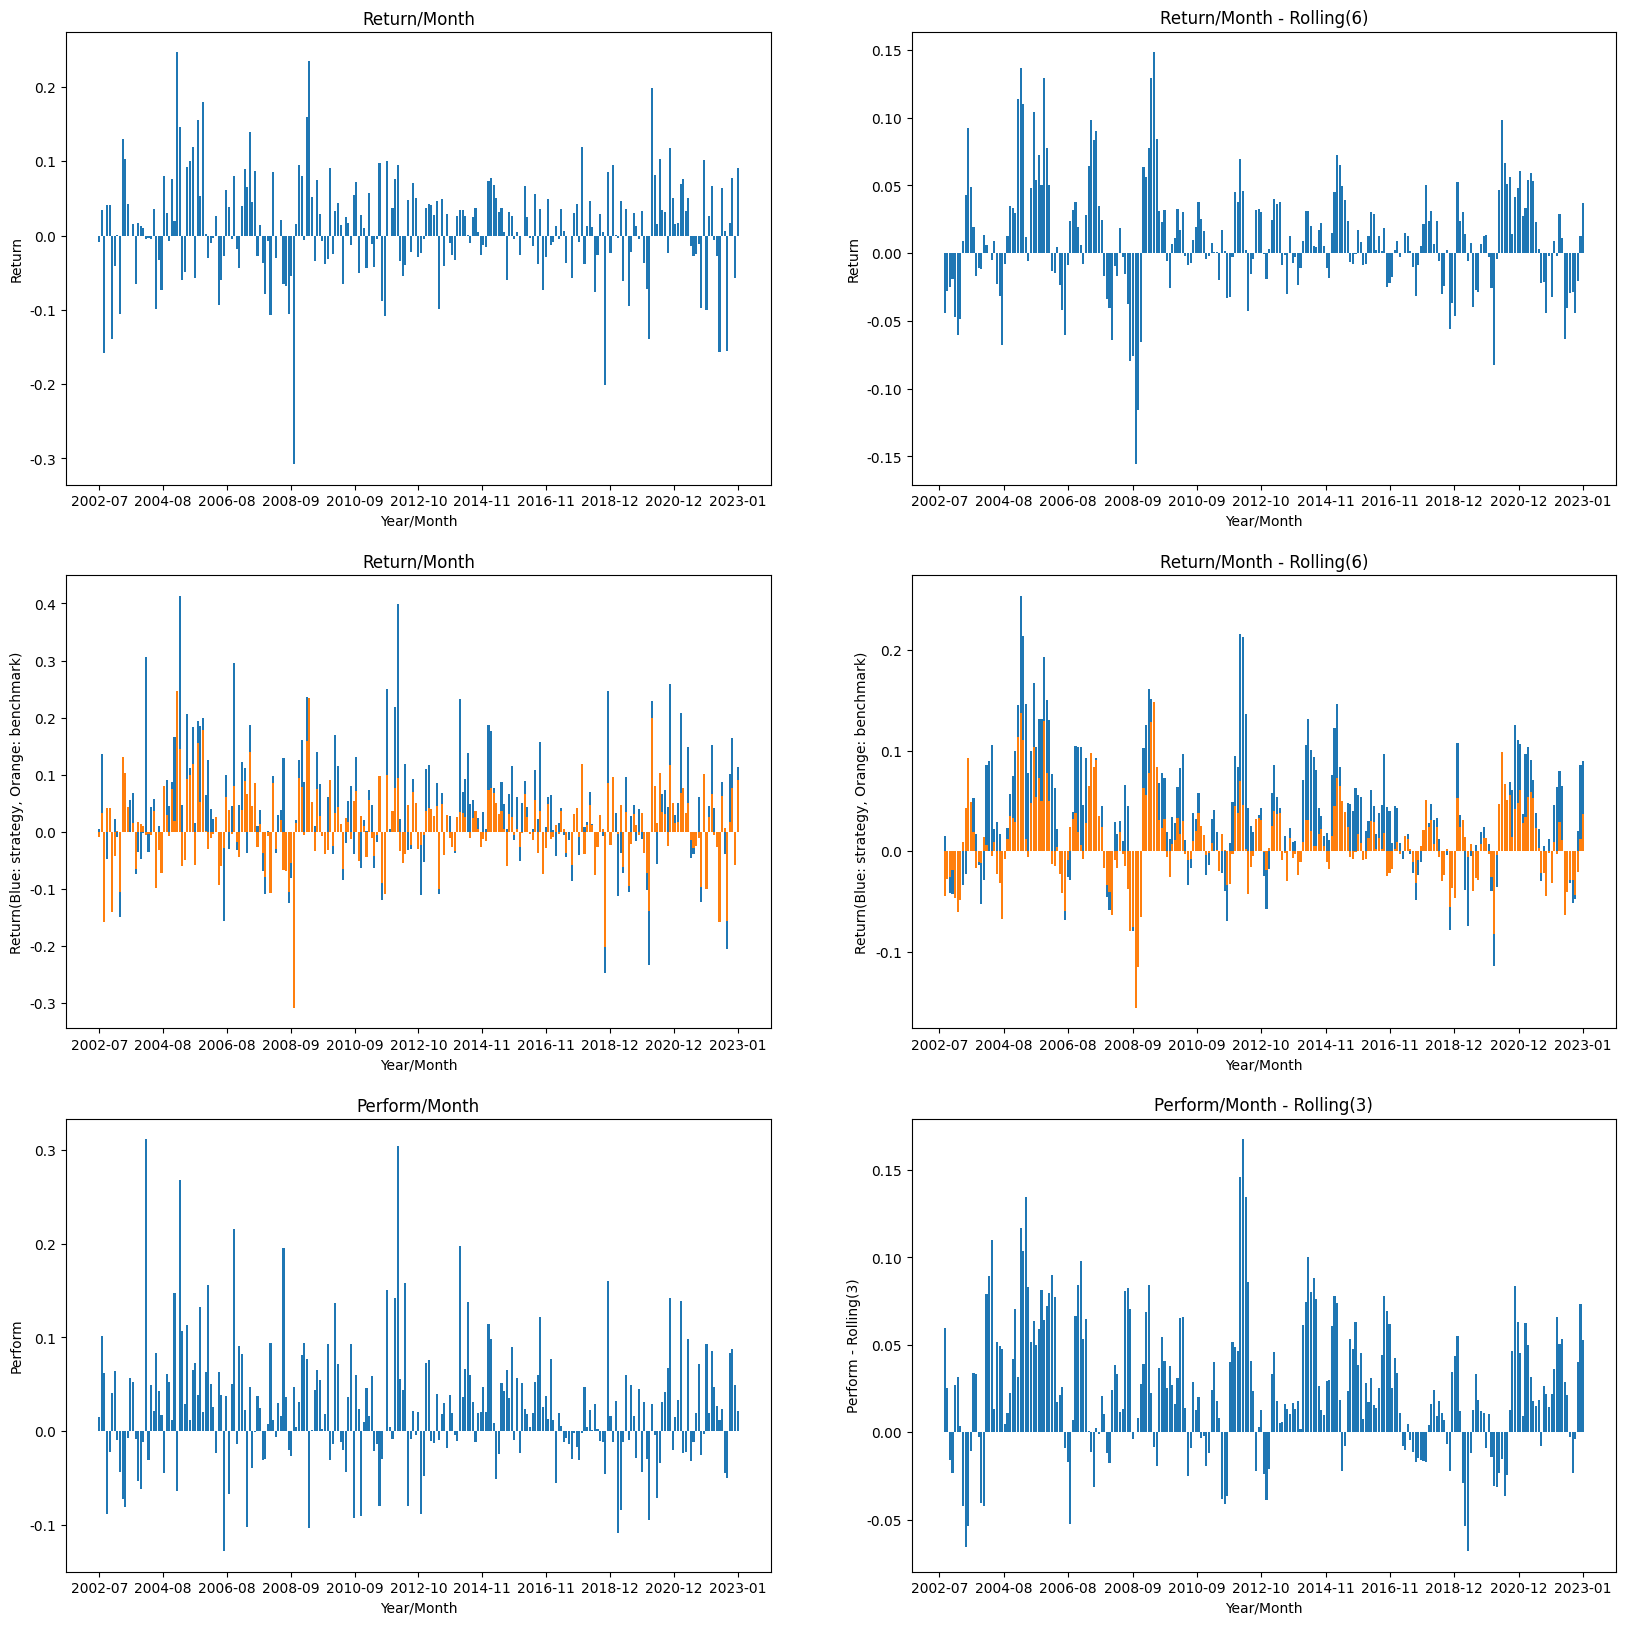

In [6]:
import numpy as np
import matplotlib.pyplot as plt

months = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(months, revisions["벤치마크 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(months, revisions["전략 수익률"])
ax3.bar(months, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(months, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(months, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(months, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(months, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})